In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.004, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9600e-01, 9.9196e-01, 9.8789e-01, 9.8379e-01, 9.7965e-01, 9.7547e-01,
        9.7127e-01, 9.6703e-01, 9.6276e-01, 9.5845e-01, 9.5412e-01, 9.4976e-01,
        9.4536e-01, 9.4094e-01, 9.3649e-01, 9.3201e-01, 9.2751e-01, 9.2298e-01,
        9.1842e-01, 9.1384e-01, 9.0923e-01, 9.0460e-01, 8.9994e-01, 8.9526e-01,
        8.9056e-01, 8.8584e-01, 8.8110e-01, 8.7633e-01, 8.7155e-01, 8.6675e-01,
        8.6192e-01, 8.5708e-01, 8.5223e-01, 8.4735e-01, 8.4246e-01, 8.3756e-01,
        8.3264e-01, 8.2770e-01, 8.2275e-01, 8.1779e-01, 8.1281e-01, 8.0782e-01,
        8.0282e-01, 7.9781e-01, 7.9279e-01, 7.8776e-01, 7.8273e-01, 7.7768e-01,
        7.7262e-01, 7.6756e-01, 7.6249e-01, 7.5741e-01, 7.5233e-01, 7.4724e-01,
        7.4215e-01, 7.3706e-01, 7.3196e-01, 7.2686e-01, 7.2175e-01, 7.1665e-01,
        7.1154e-01, 7.0643e-01, 7.0132e-01, 6.9622e-01, 6.9111e-01, 6.8601e-01,
        6.8090e-01, 6.7580e-01, 6.7070e-01, 6.6561e-01, 6.6052e-01, 6.5543e-01,
        6.5035e-01, 6.4528e-01, 6.4021e-

torch.Size([4, 3, 72, 72])


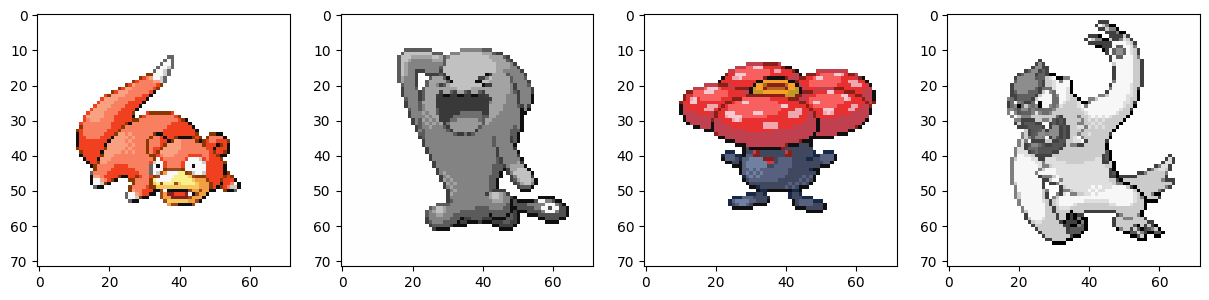

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Grass"], ["Fire"], ["Water"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

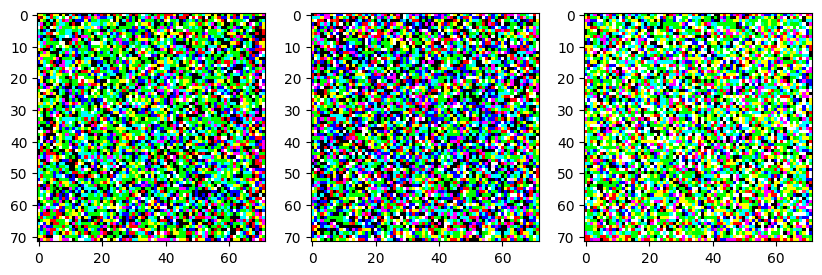

0.03741518:   1%|          | 1000/100001 [00:50<1:18:16, 21.08it/s]

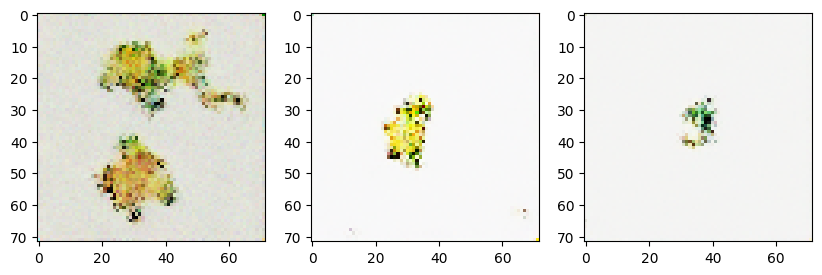

0.06368240:   2%|▏         | 1999/100001 [01:40<1:17:55, 20.96it/s]

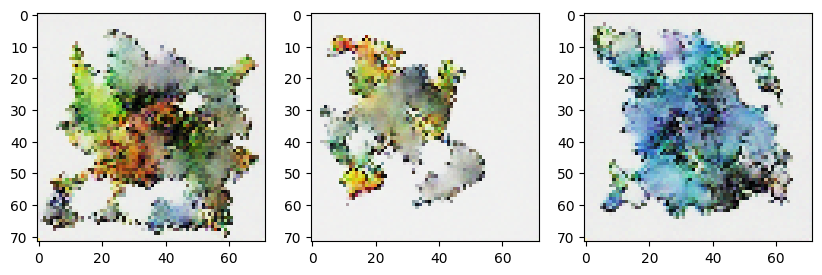

0.04733523:   3%|▎         | 2998/100001 [02:31<1:17:17, 20.92it/s]

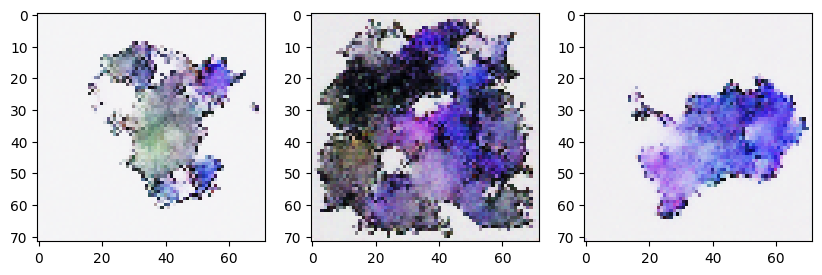

0.02850632:   4%|▍         | 4000/100001 [03:21<1:16:33, 20.90it/s]

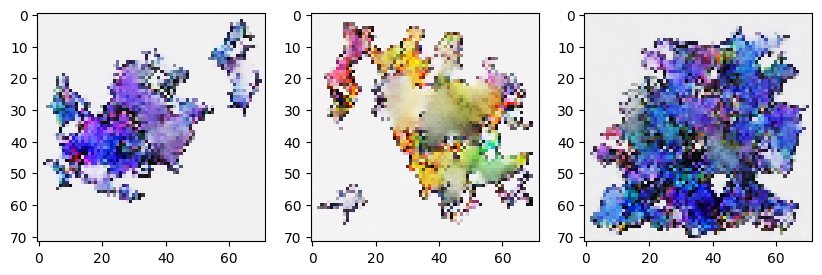

0.03935622:   5%|▍         | 4999/100001 [04:12<1:15:37, 20.94it/s]

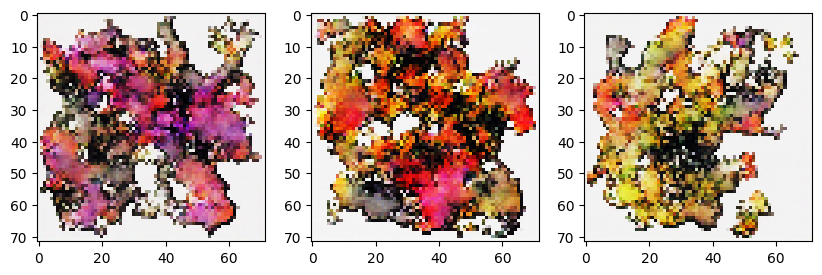

0.04659624:   6%|▌         | 5998/100001 [05:02<1:14:43, 20.97it/s]

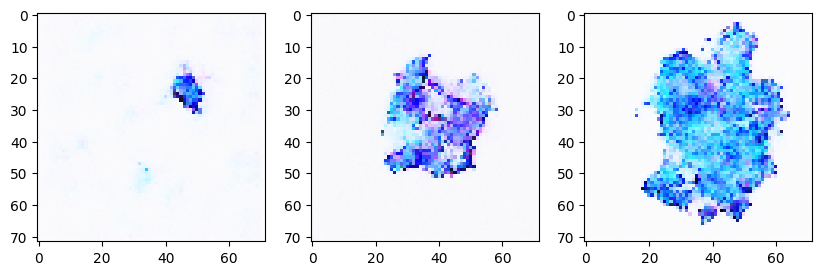

0.08133052:   7%|▋         | 7000/100001 [05:53<1:14:04, 20.93it/s]

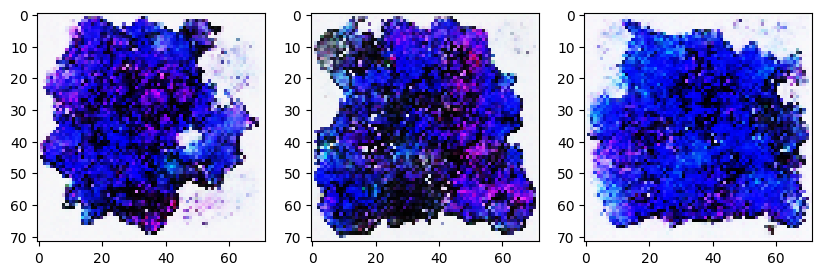

0.03207989:   8%|▊         | 7999/100001 [06:43<1:13:17, 20.92it/s]

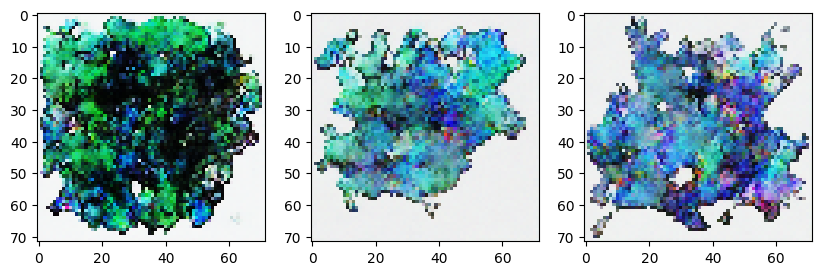

0.02547828:   9%|▉         | 8998/100001 [07:34<1:12:29, 20.92it/s]

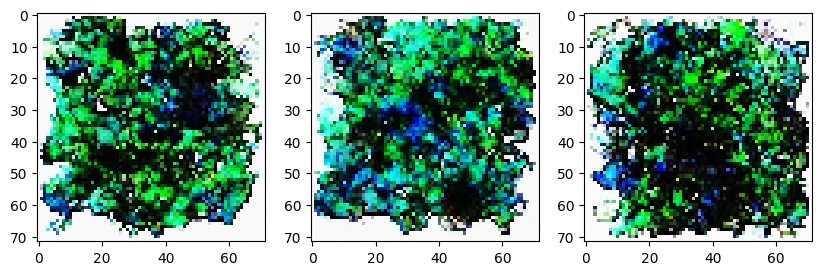

0.03983117:  10%|▉         | 10000/100001 [08:24<1:11:37, 20.94it/s]

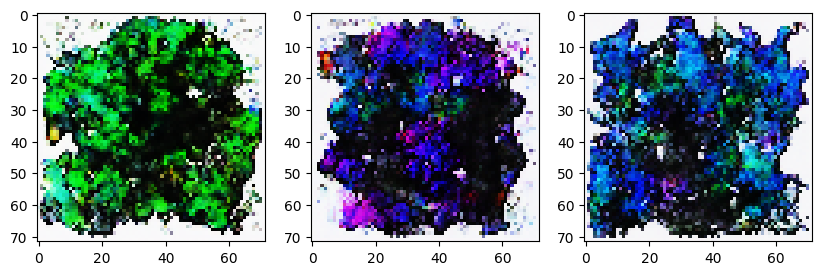

0.04988162:  11%|█         | 10999/100001 [09:15<1:10:52, 20.93it/s]

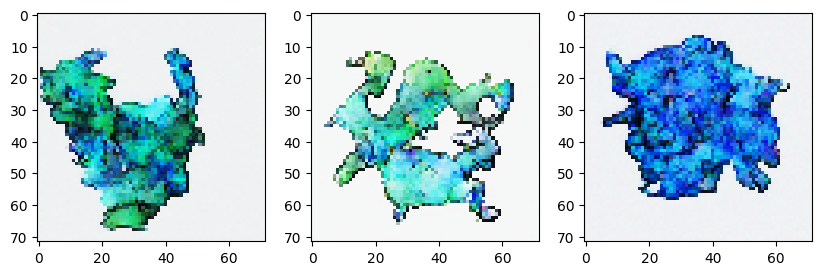

0.04179432:  12%|█▏        | 11998/100001 [10:05<1:09:57, 20.97it/s]

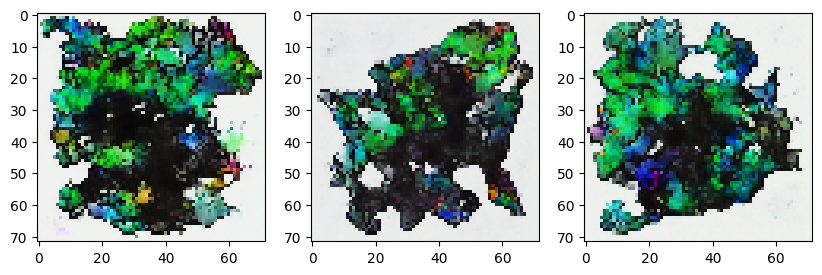

0.01816505:  13%|█▎        | 13000/100001 [10:55<1:09:16, 20.93it/s]

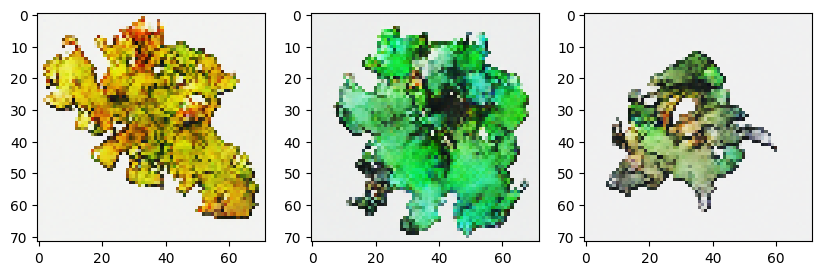

0.04571711:  14%|█▍        | 13999/100001 [11:46<1:08:21, 20.97it/s]

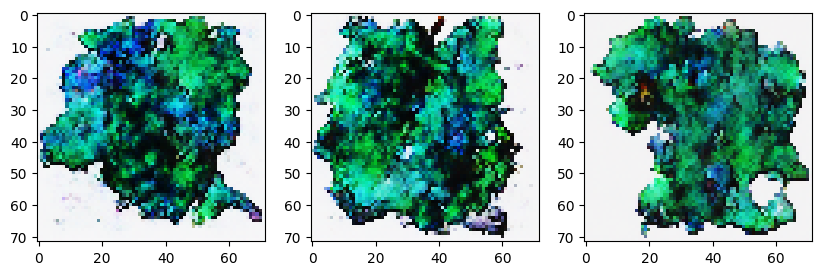

0.03310934:  15%|█▍        | 14998/100001 [12:36<1:07:34, 20.96it/s]

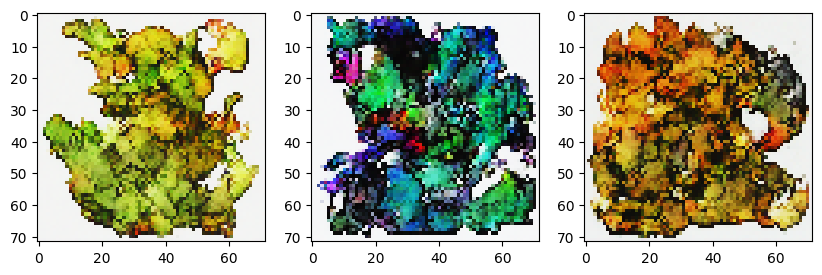

0.01912582:  16%|█▌        | 16000/100001 [13:27<1:06:47, 20.96it/s]

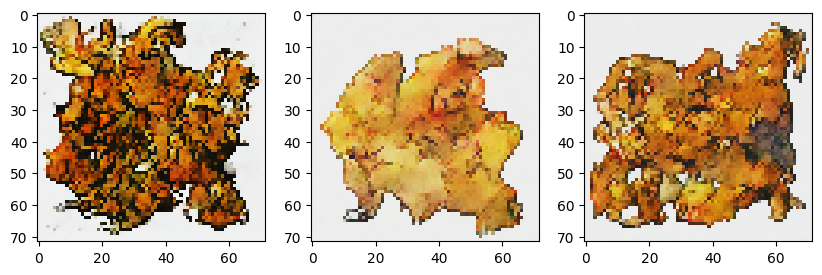

0.03707666:  17%|█▋        | 16999/100001 [14:17<1:06:00, 20.96it/s]

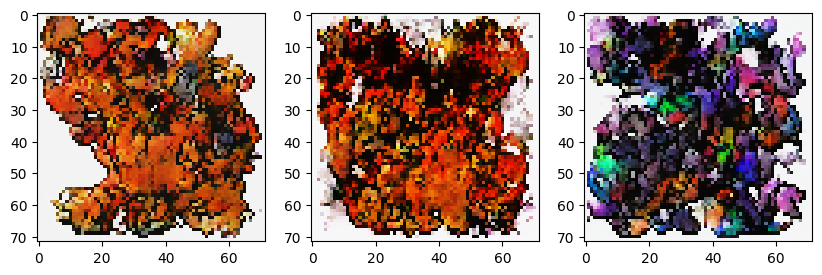

0.01823005:  18%|█▊        | 17998/100001 [15:07<1:05:10, 20.97it/s]

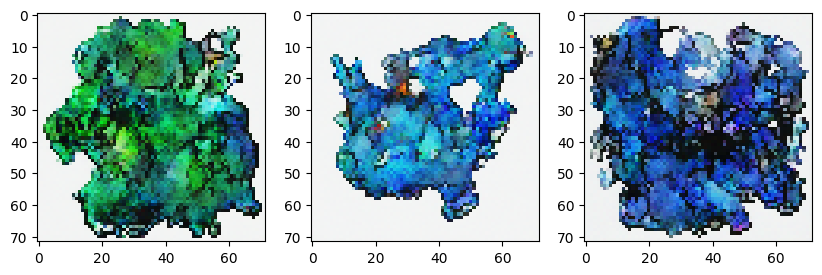

0.03750335:  19%|█▉        | 19000/100001 [15:58<1:04:31, 20.92it/s]

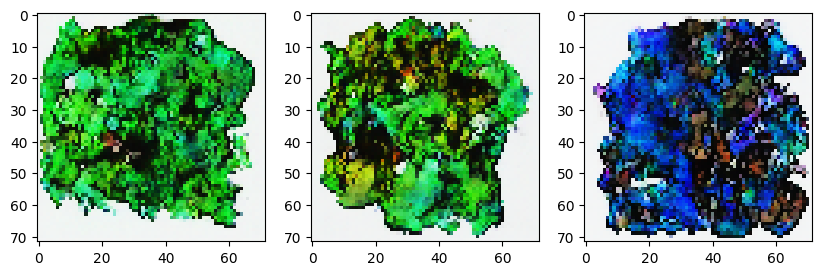

0.04907728:  20%|█▉        | 19999/100001 [16:48<1:03:32, 20.98it/s]

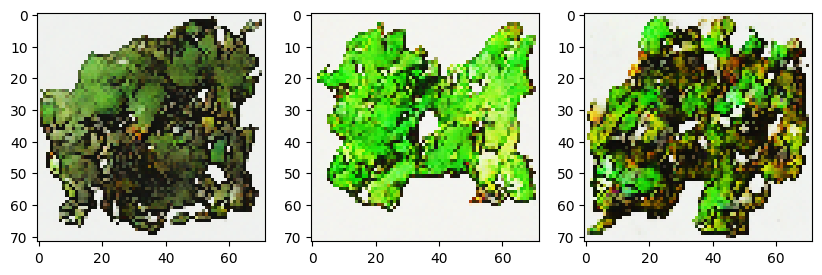

0.04534920:  21%|██        | 20998/100001 [17:39<1:02:44, 20.98it/s]

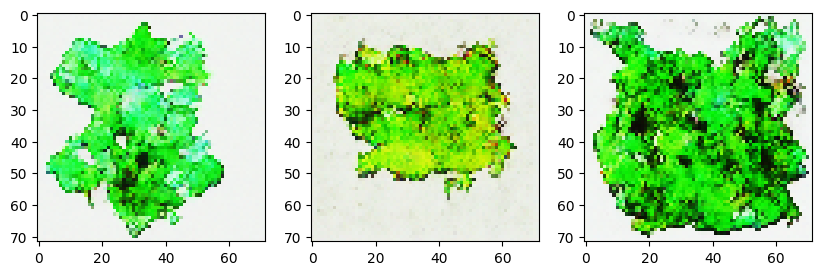

0.04479596:  22%|██▏       | 22000/100001 [18:29<1:02:01, 20.96it/s]

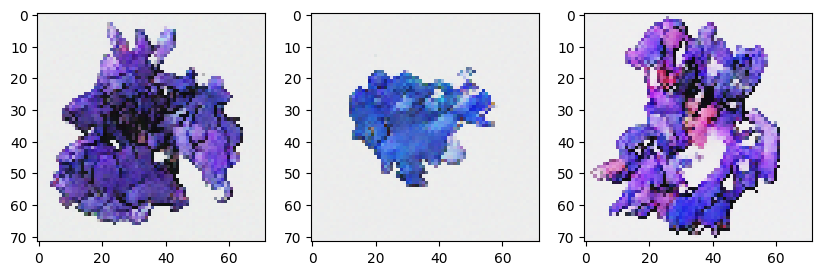

0.02069973:  23%|██▎       | 22999/100001 [19:20<1:01:17, 20.94it/s]

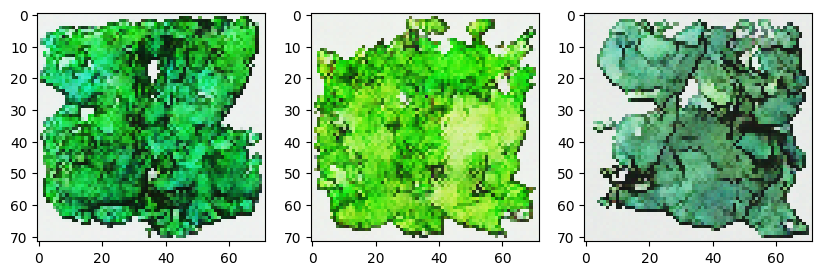

0.02491341:  24%|██▍       | 23998/100001 [20:10<1:00:27, 20.95it/s]

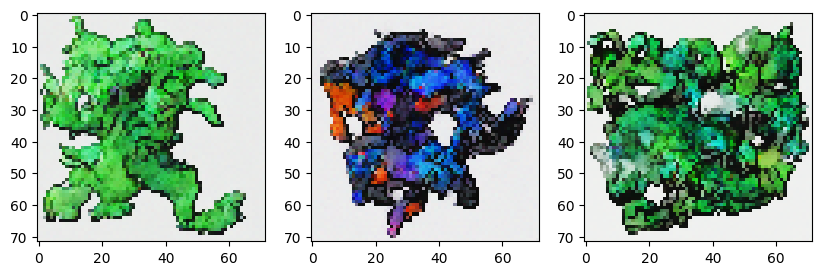

0.04471241:  25%|██▍       | 25000/100001 [21:01<59:38, 20.96it/s]  

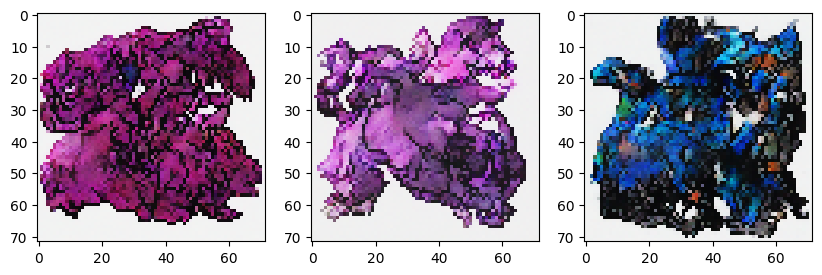

0.02118432:  26%|██▌       | 25999/100001 [21:51<58:49, 20.97it/s]  

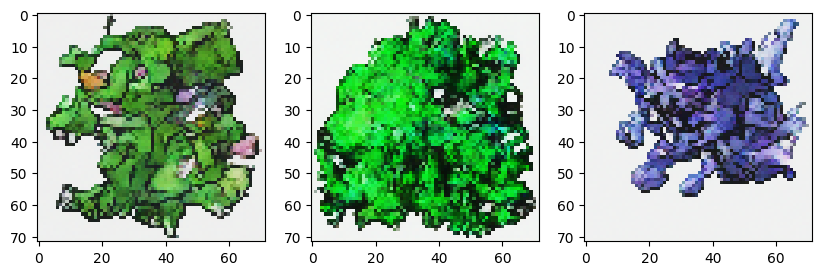

0.02053636:  27%|██▋       | 26998/100001 [22:41<58:05, 20.94it/s]  

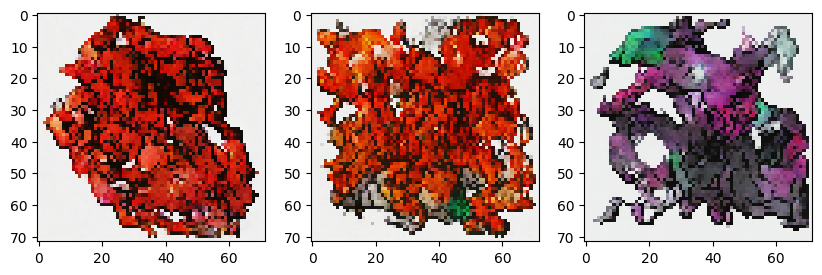

0.03421504:  28%|██▊       | 28000/100001 [23:32<57:18, 20.94it/s]  

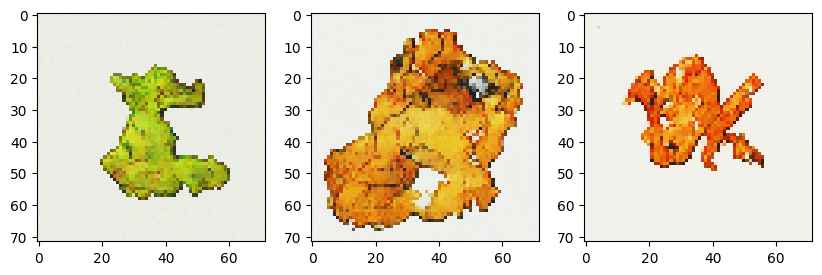

0.02372913:  29%|██▉       | 28999/100001 [24:22<56:31, 20.93it/s]  

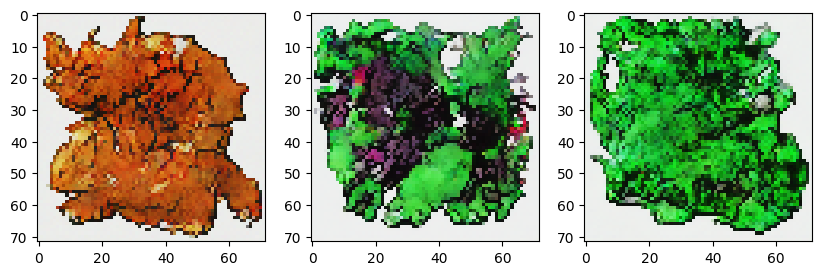

0.04066068:  30%|██▉       | 29998/100001 [25:13<55:40, 20.96it/s]  

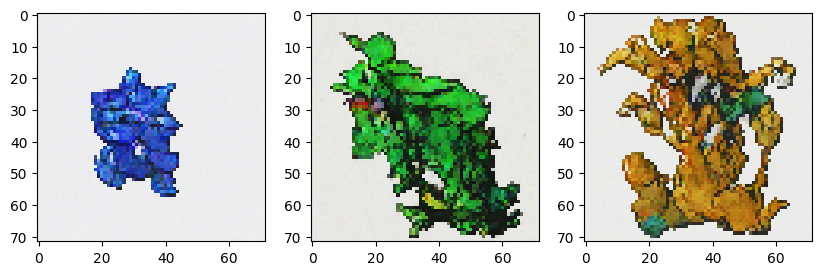

0.02044337:  31%|███       | 31000/100001 [26:03<54:52, 20.96it/s]  

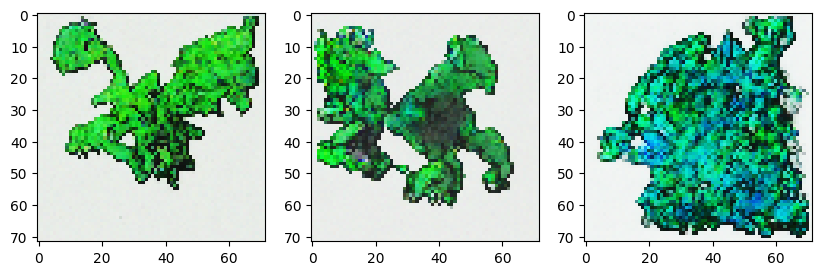

0.01396680:  32%|███▏      | 31999/100001 [26:53<54:08, 20.94it/s]  

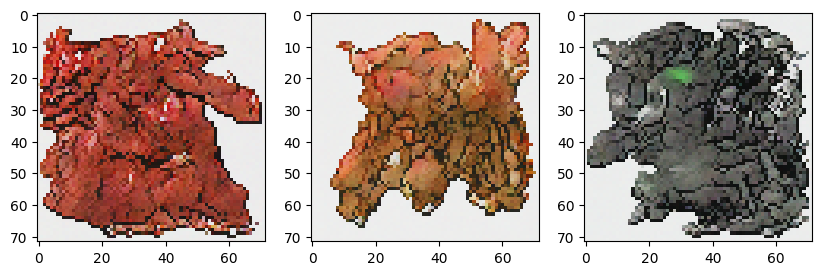

0.02608470:  33%|███▎      | 32998/100001 [27:44<53:18, 20.95it/s]  

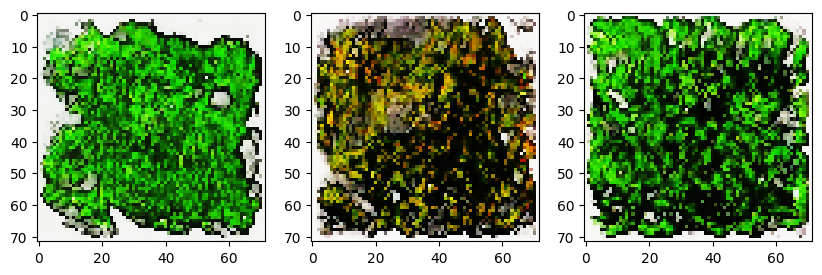

0.03310633:  34%|███▍      | 34000/100001 [28:34<52:29, 20.96it/s]  

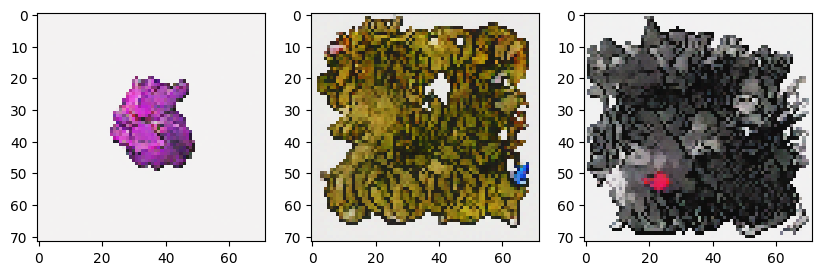

0.02462658:  35%|███▍      | 34999/100001 [29:25<51:45, 20.93it/s]  

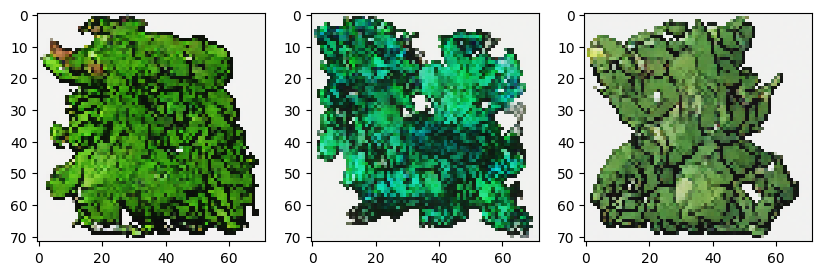

0.02778437:  36%|███▌      | 35998/100001 [30:15<50:58, 20.93it/s]  

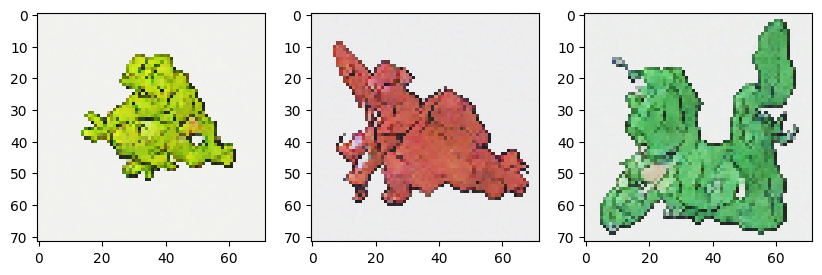

0.01657427:  37%|███▋      | 37000/100001 [31:06<50:05, 20.96it/s]  

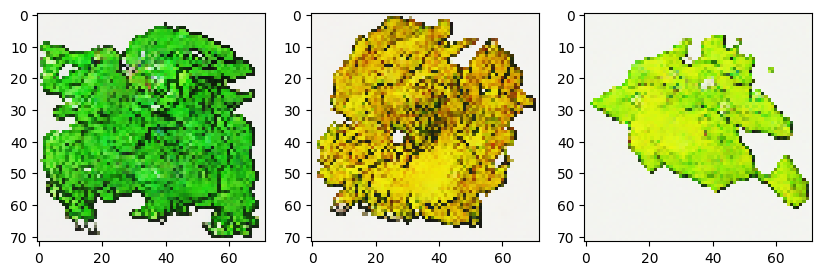

0.02292620:  38%|███▊      | 37999/100001 [31:56<49:18, 20.96it/s]  

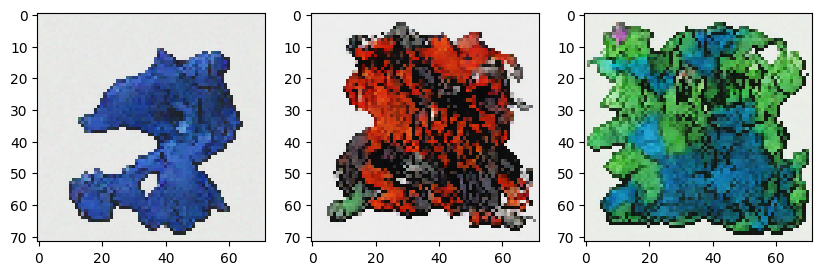

0.01277015:  39%|███▉      | 38998/100001 [32:47<48:36, 20.92it/s]  

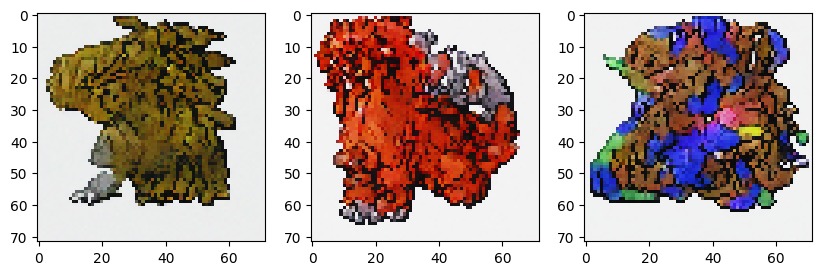

0.01189044:  40%|███▉      | 40000/100001 [33:37<47:43, 20.95it/s]  

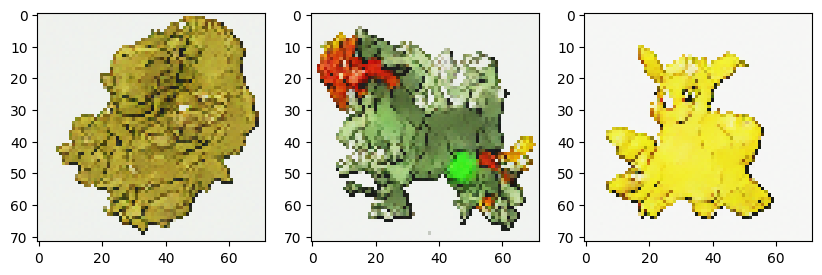

0.01024486:  41%|████      | 40999/100001 [34:28<47:01, 20.91it/s]  

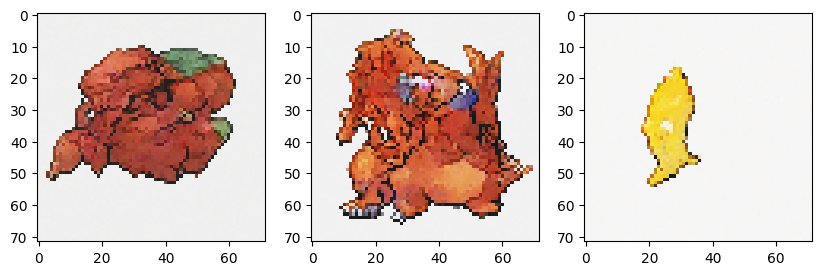

0.04094059:  42%|████▏     | 41998/100001 [35:18<46:07, 20.96it/s]  

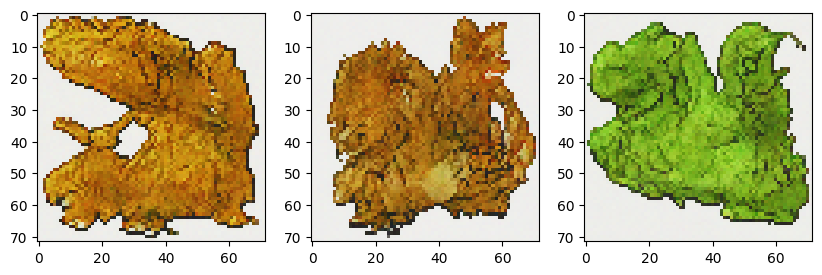

0.02762241:  43%|████▎     | 43000/100001 [36:09<45:23, 20.93it/s]  

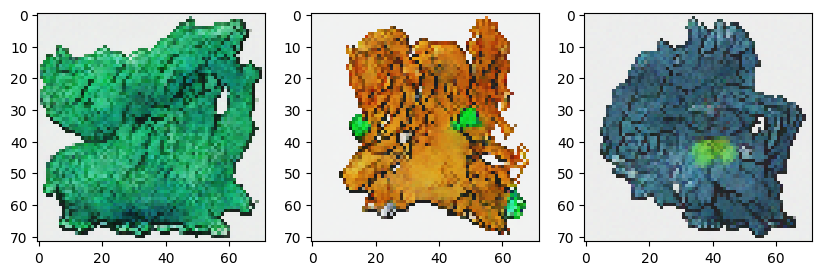

0.02561233:  44%|████▍     | 43999/100001 [36:59<44:33, 20.95it/s]  

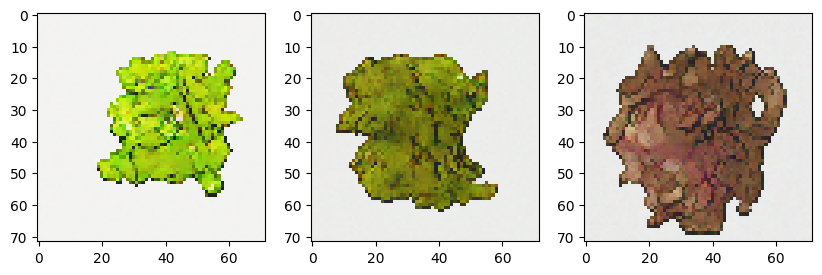

0.02677467:  45%|████▍     | 44998/100001 [37:49<43:45, 20.95it/s]  

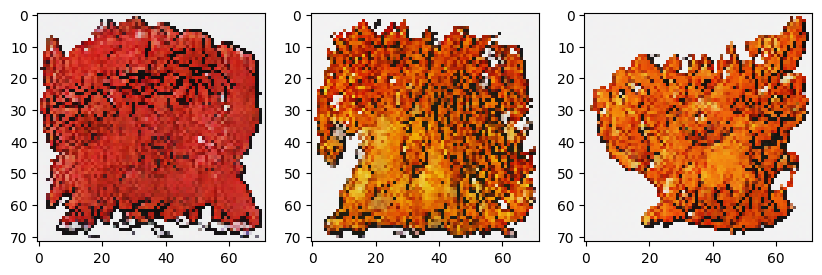

0.01653927:  46%|████▌     | 46000/100001 [38:40<42:53, 20.98it/s]  

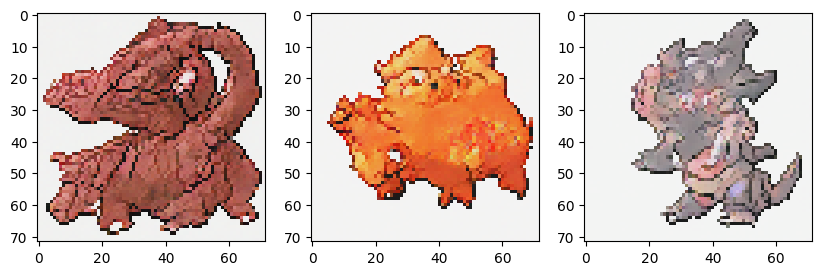

0.01443467:  47%|████▋     | 46999/100001 [39:30<42:15, 20.90it/s]  

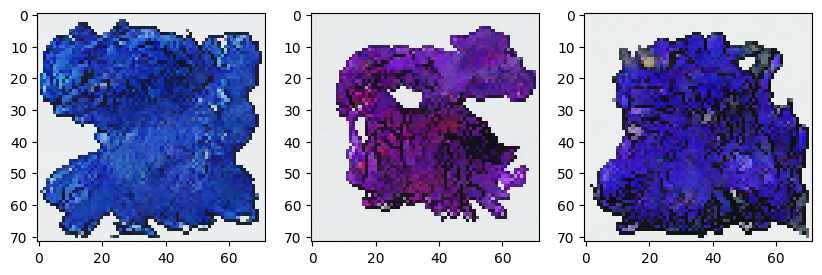

0.02610581:  48%|████▊     | 47998/100001 [40:21<41:22, 20.95it/s]  

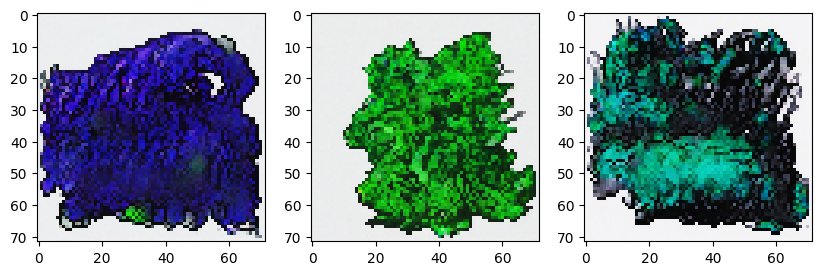

0.02028435:  49%|████▉     | 49000/100001 [41:11<40:35, 20.94it/s]  

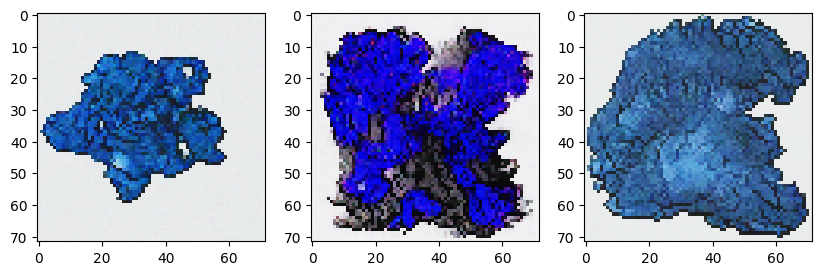

0.01779972:  50%|████▉     | 49999/100001 [42:02<39:45, 20.96it/s]  

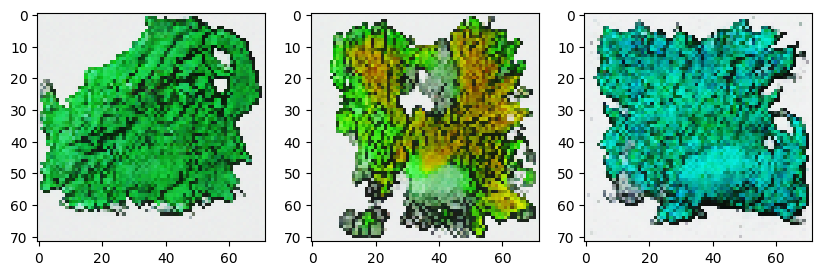

0.01380470:  51%|█████     | 50998/100001 [42:52<38:58, 20.96it/s]  

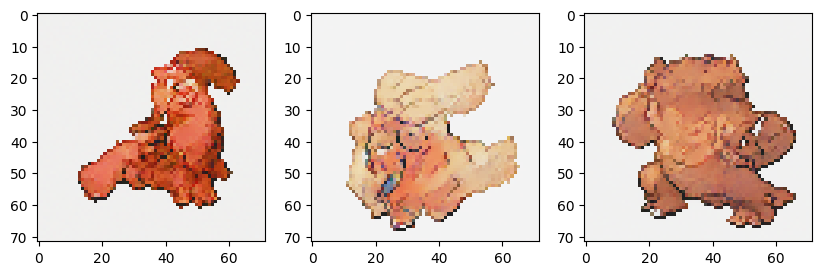

0.03666922:  52%|█████▏    | 52000/100001 [43:42<38:10, 20.96it/s]  

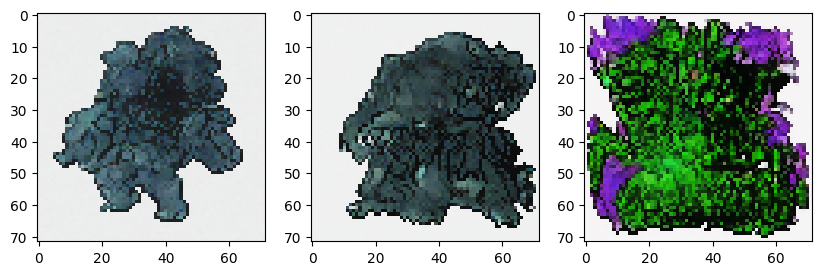

0.02746143:  53%|█████▎    | 52999/100001 [44:33<37:24, 20.94it/s]  

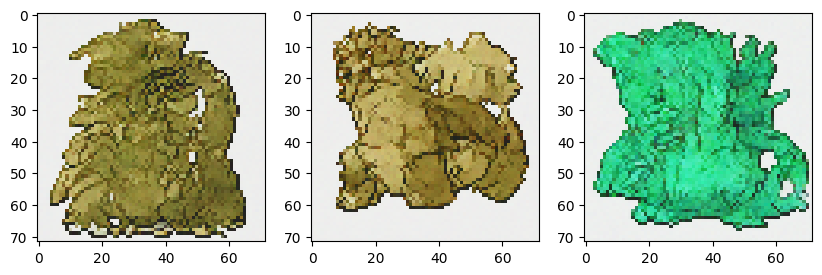

0.01195394:  54%|█████▍    | 53998/100001 [45:23<36:38, 20.93it/s]  

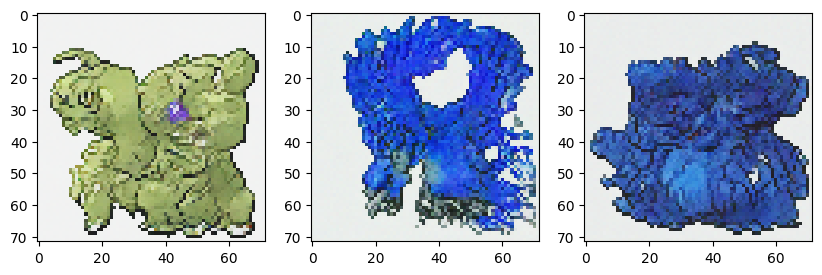

0.01691785:  55%|█████▍    | 55000/100001 [46:14<35:50, 20.93it/s]  

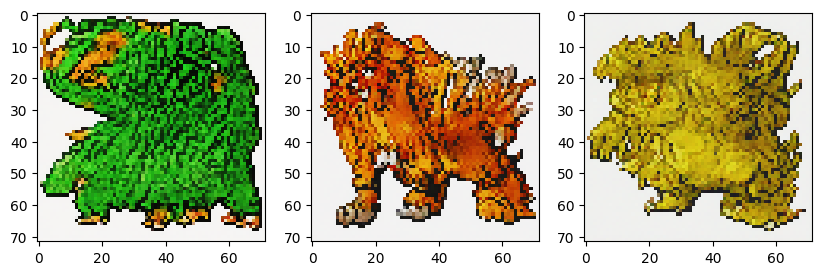

0.02621472:  56%|█████▌    | 55999/100001 [47:04<35:00, 20.95it/s]  

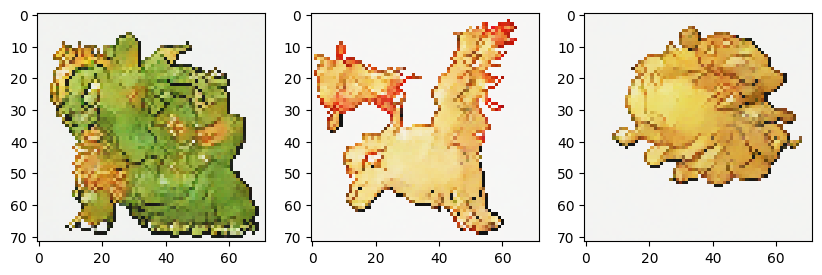

0.02983859:  57%|█████▋    | 56998/100001 [47:55<34:10, 20.98it/s]  

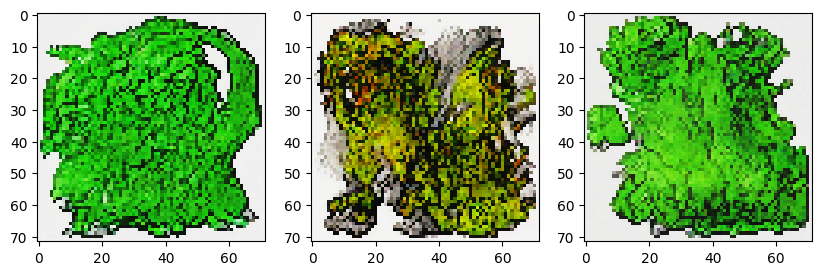

0.02031313:  58%|█████▊    | 58000/100001 [48:45<33:22, 20.97it/s]  

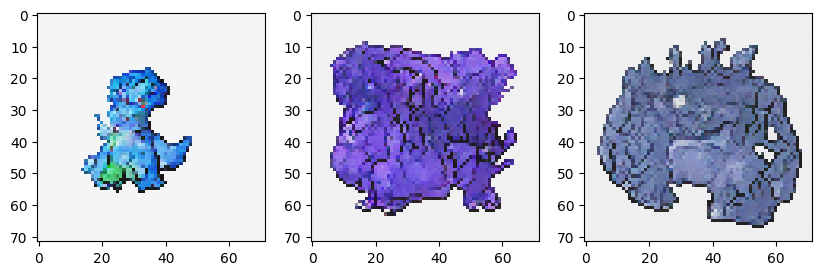

0.01273377:  59%|█████▉    | 58999/100001 [49:36<32:38, 20.94it/s]  

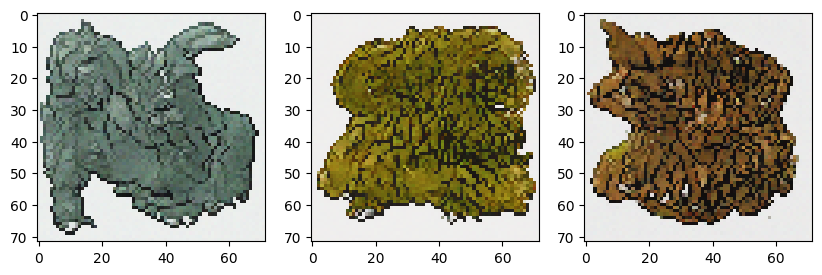

0.02418329:  60%|█████▉    | 59998/100001 [50:26<31:51, 20.93it/s]  

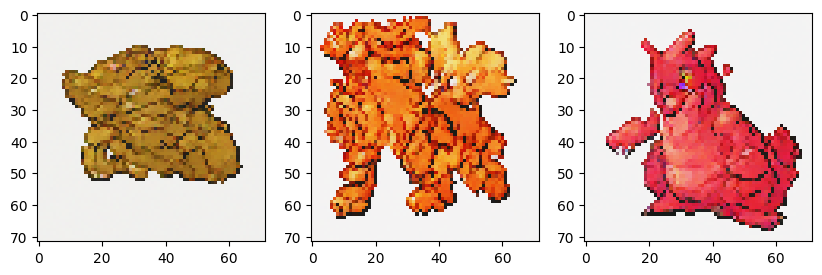

0.03635501:  61%|██████    | 61000/100001 [51:17<31:04, 20.92it/s]  

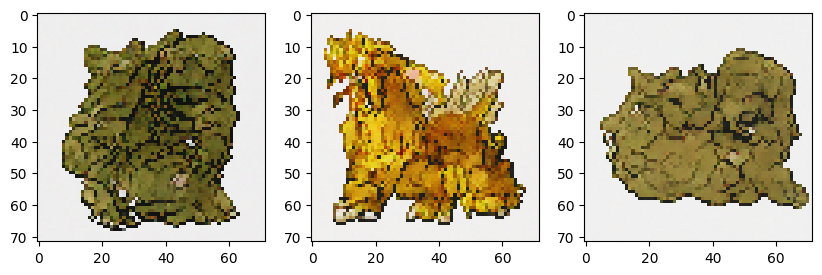

0.01374100:  62%|██████▏   | 61999/100001 [52:07<30:12, 20.97it/s]  

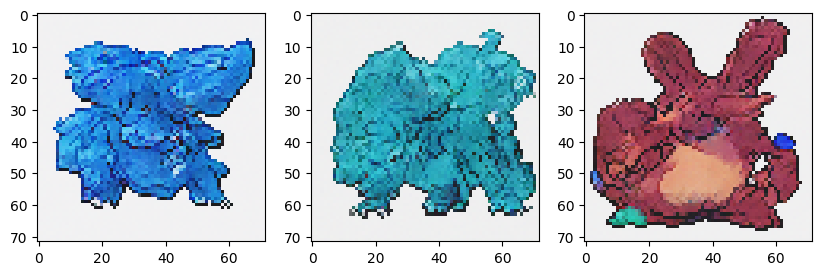

0.01830185:  63%|██████▎   | 62998/100001 [52:57<29:26, 20.94it/s]  

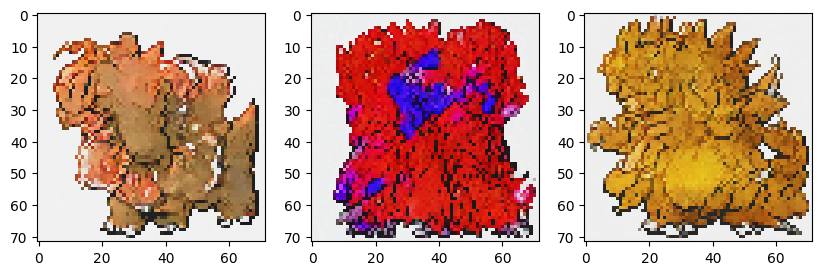

0.03386702:  64%|██████▍   | 64000/100001 [53:48<28:39, 20.93it/s]  

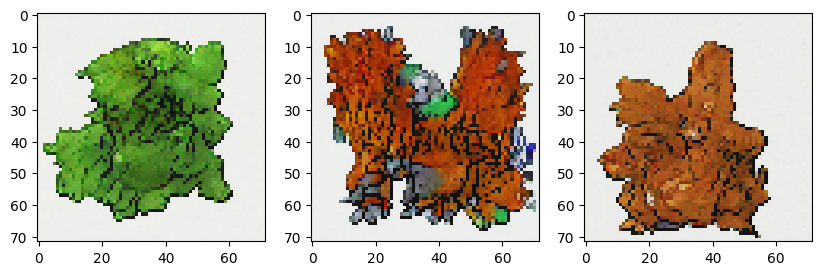

0.02154329:  65%|██████▍   | 64999/100001 [54:38<27:54, 20.90it/s]  

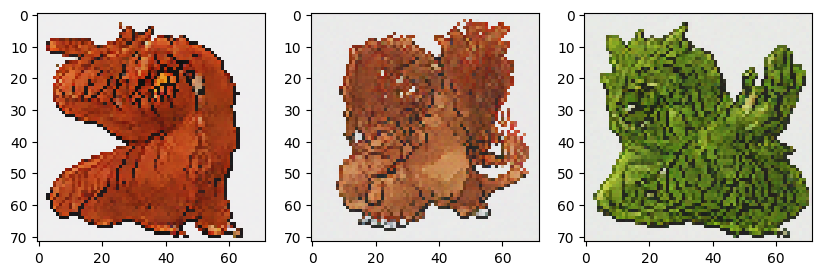

0.02435444:  66%|██████▌   | 65998/100001 [55:29<27:03, 20.94it/s]  

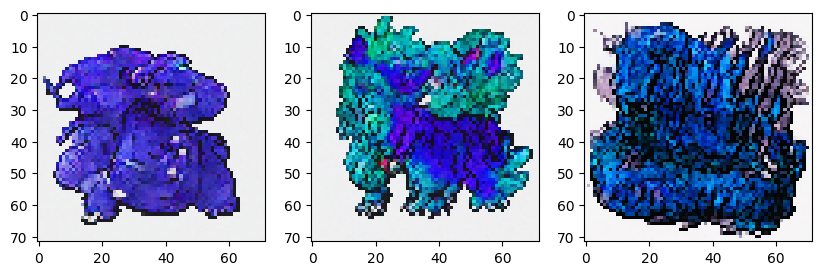

0.02810783:  67%|██████▋   | 67000/100001 [56:19<26:18, 20.91it/s]  

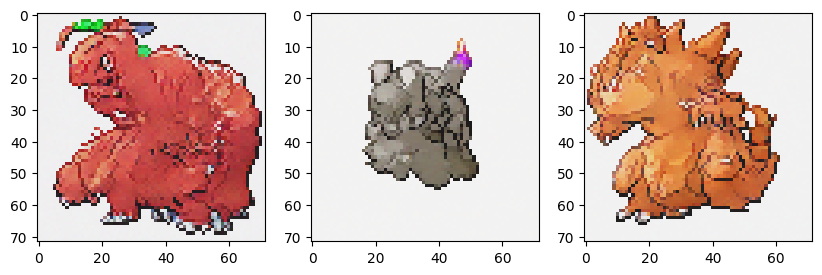

0.02769939:  68%|██████▊   | 67999/100001 [57:10<25:25, 20.97it/s]  

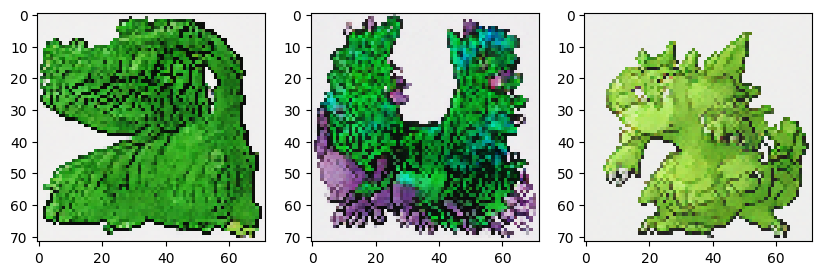

0.01140461:  69%|██████▉   | 68998/100001 [58:00<24:39, 20.96it/s]  

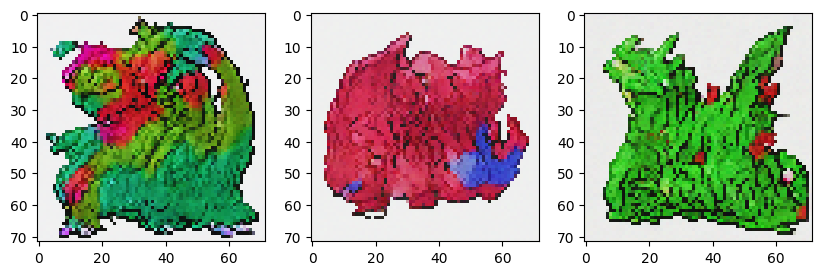

0.02590005:  70%|██████▉   | 70000/100001 [58:51<23:50, 20.98it/s]  

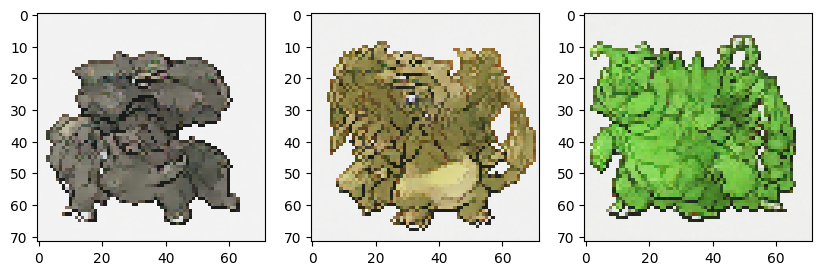

0.02897407:  71%|███████   | 70999/100001 [59:41<23:05, 20.93it/s]  

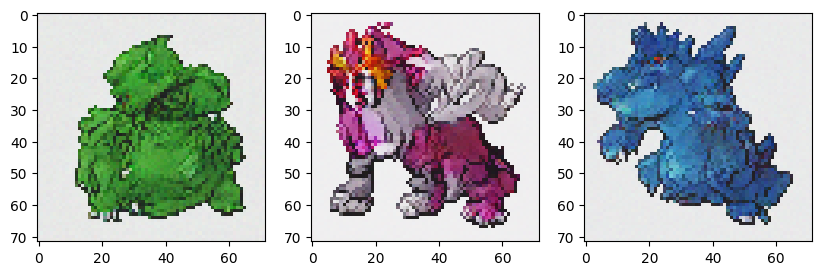

0.01766901:  72%|███████▏  | 71998/100001 [1:00:32<22:17, 20.94it/s]

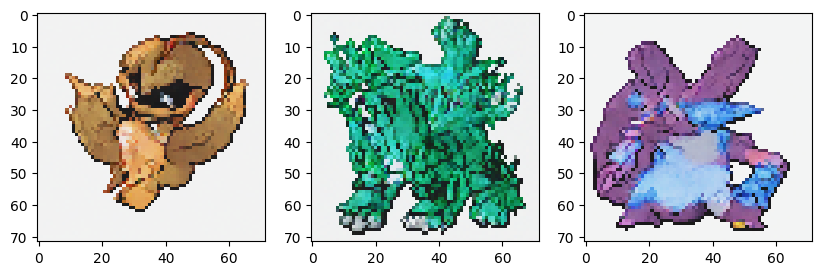

0.01312984:  73%|███████▎  | 73000/100001 [1:01:22<21:31, 20.90it/s]  

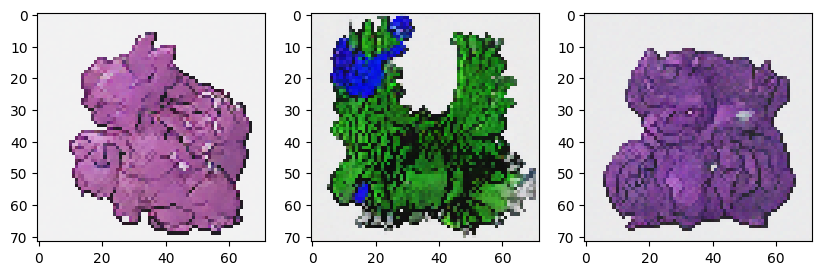

0.01750939:  74%|███████▍  | 73999/100001 [1:02:13<20:44, 20.89it/s]  

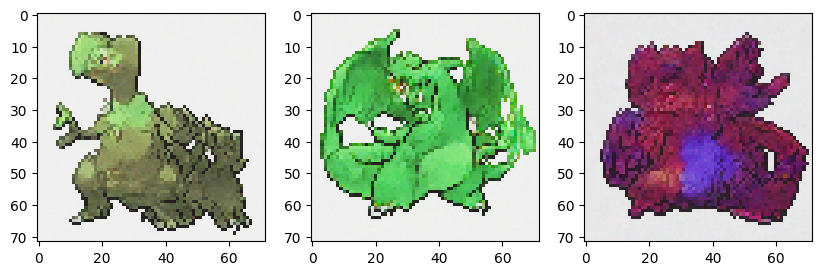

0.00904239:  75%|███████▍  | 74998/100001 [1:03:03<19:53, 20.95it/s]  

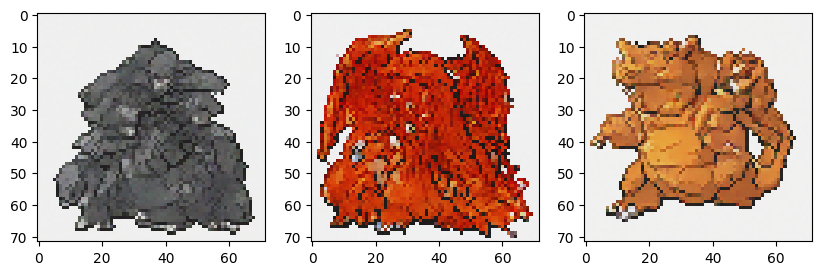

0.02367351:  76%|███████▌  | 76000/100001 [1:03:54<19:05, 20.95it/s]  

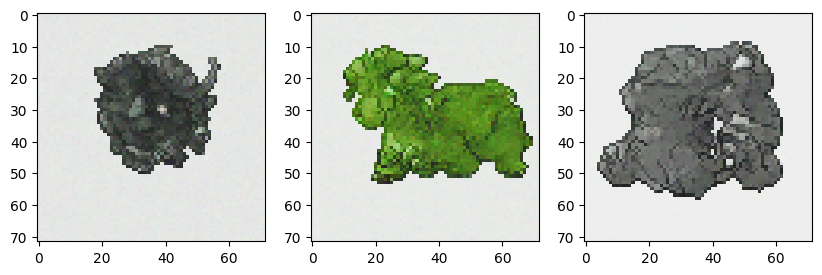

0.01250409:  77%|███████▋  | 76999/100001 [1:04:44<18:16, 20.98it/s]  

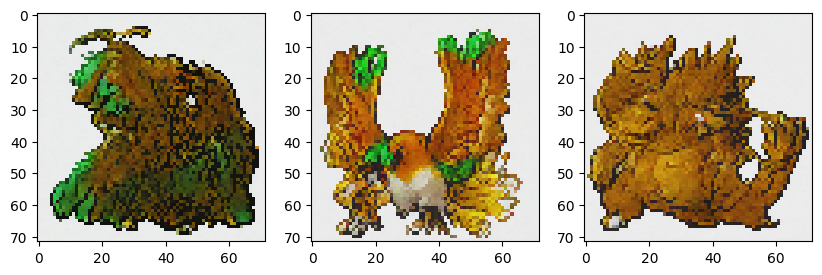

0.01427531:  78%|███████▊  | 77998/100001 [1:05:34<17:30, 20.96it/s]  

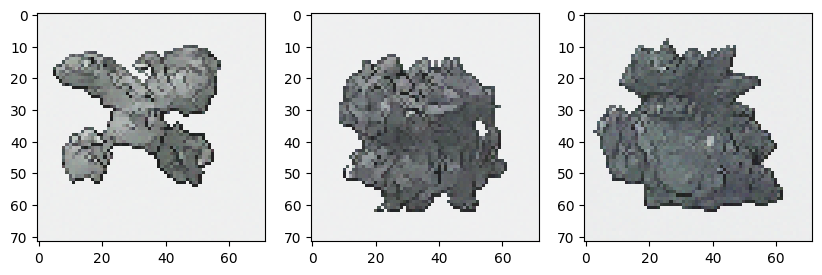

0.02622003:  79%|███████▉  | 79000/100001 [1:06:25<16:42, 20.94it/s]  

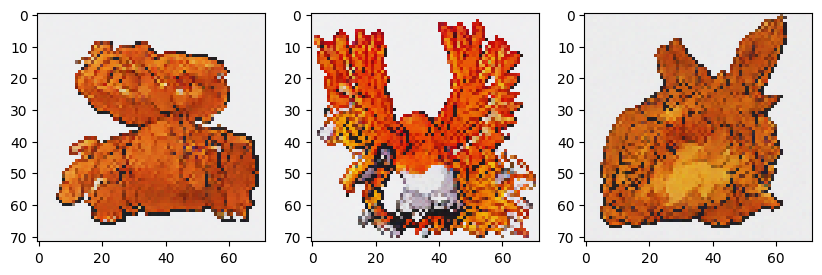

0.02678135:  80%|███████▉  | 79999/100001 [1:07:15<15:56, 20.91it/s]  

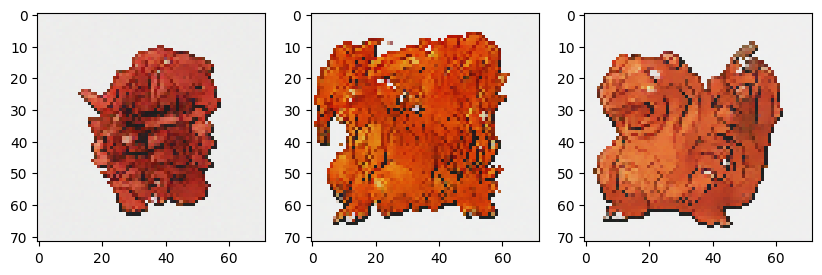

0.02140051:  81%|████████  | 80998/100001 [1:08:06<15:08, 20.92it/s]  

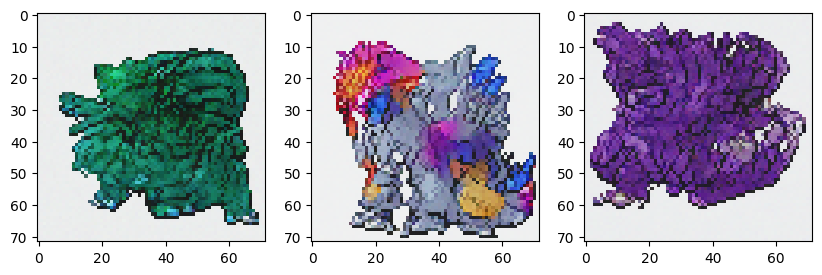

0.01570452:  82%|████████▏ | 82000/100001 [1:08:56<14:19, 20.94it/s]  

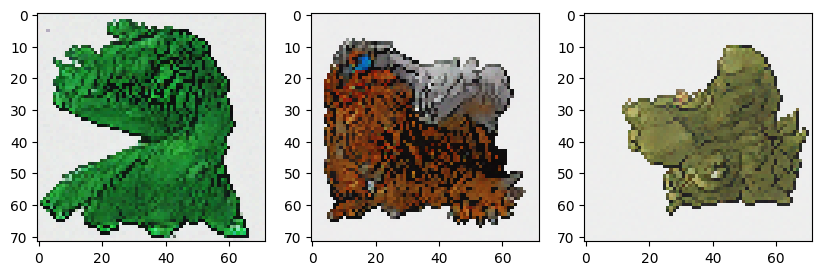

0.01431740:  83%|████████▎ | 82999/100001 [1:09:47<13:29, 20.99it/s]  

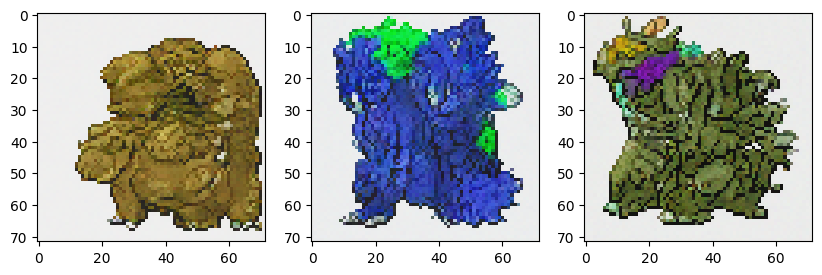

0.01009992:  84%|████████▍ | 83998/100001 [1:10:37<12:44, 20.93it/s]  

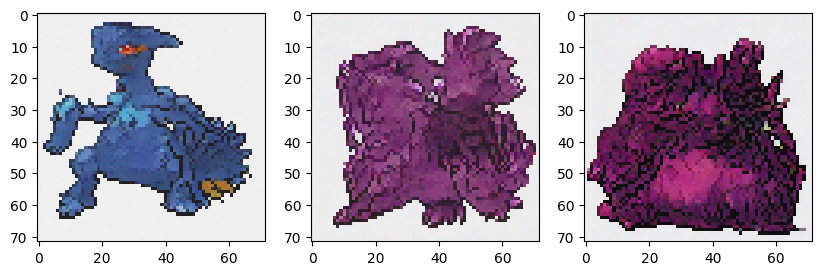

0.01543112:  85%|████████▍ | 85000/100001 [1:11:28<11:57, 20.91it/s]  

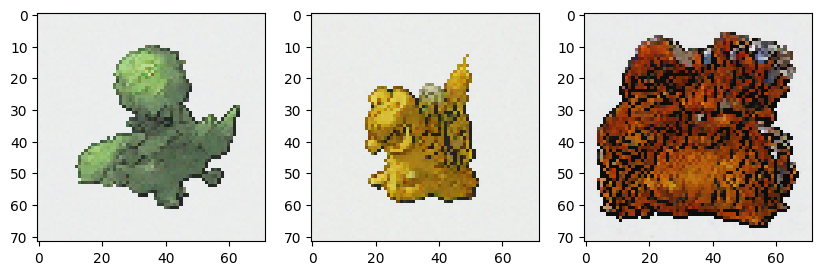

0.01294497:  86%|████████▌ | 85999/100001 [1:12:18<11:09, 20.93it/s]  

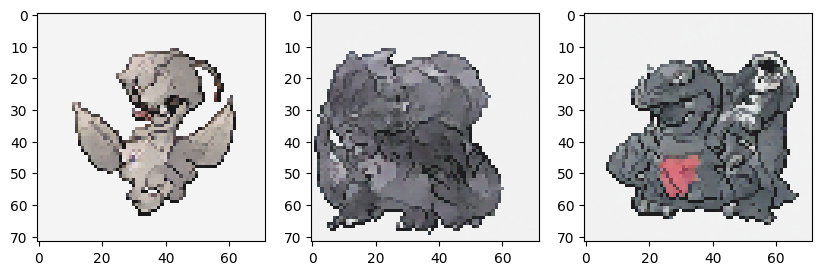

0.01647260:  87%|████████▋ | 86998/100001 [1:13:09<10:20, 20.96it/s]  

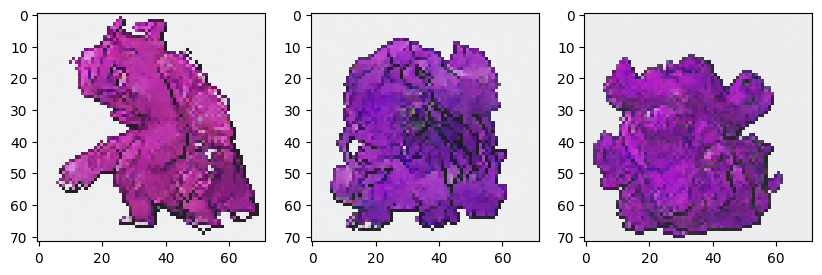

0.01063056:  88%|████████▊ | 87999/100001 [1:13:59<09:32, 20.96it/s]  

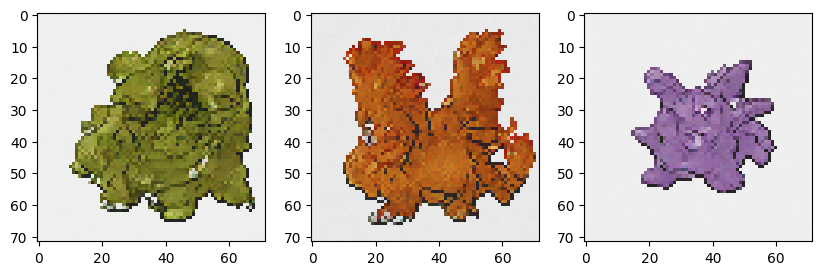

0.01118037:  89%|████████▉ | 88998/100001 [1:14:50<08:45, 20.96it/s]  

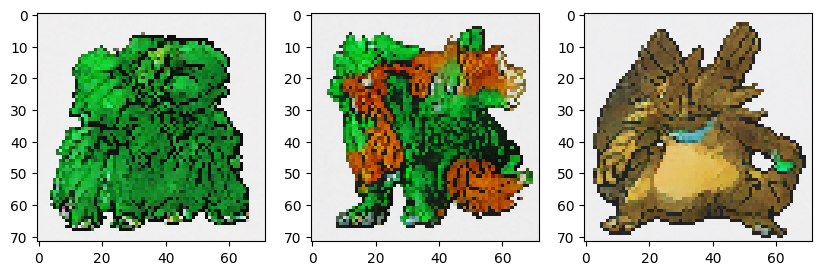

0.01192368:  90%|████████▉ | 90000/100001 [1:15:40<07:57, 20.94it/s]

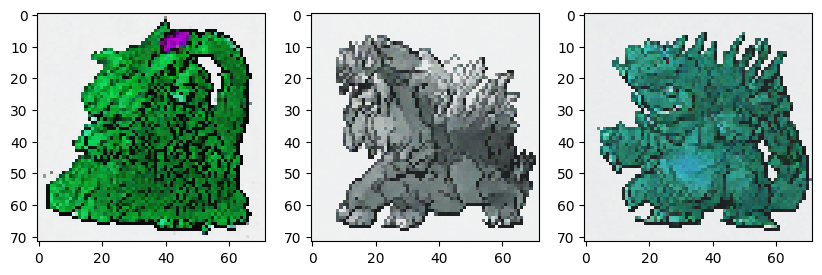

0.01933302:  91%|█████████ | 90999/100001 [1:16:30<07:09, 20.95it/s]

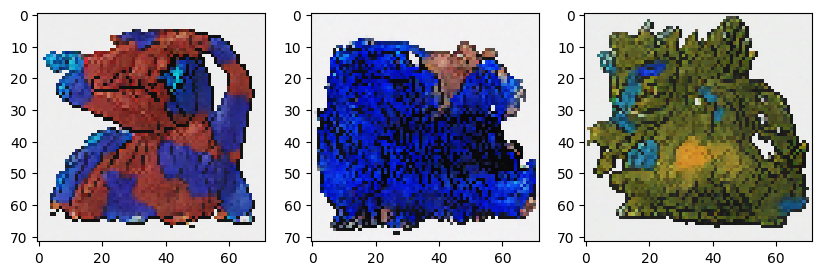

0.01633590:  92%|█████████▏| 91998/100001 [1:17:21<06:22, 20.90it/s]

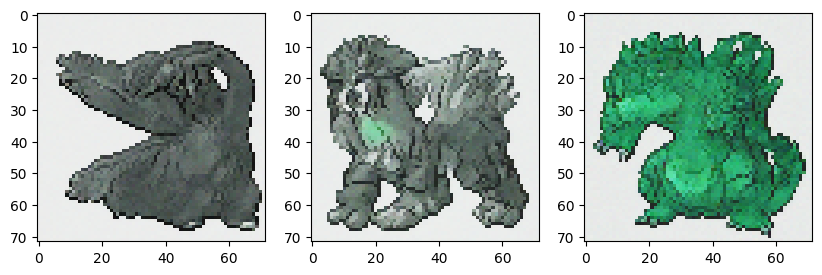

0.01524448:  93%|█████████▎| 93000/100001 [1:18:11<05:34, 20.92it/s]

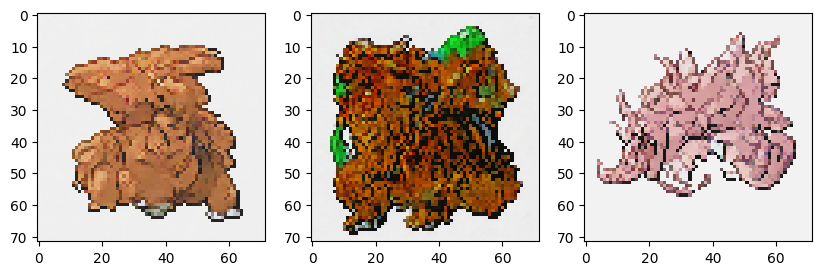

0.01594434:  94%|█████████▍| 93999/100001 [1:19:02<04:47, 20.91it/s]

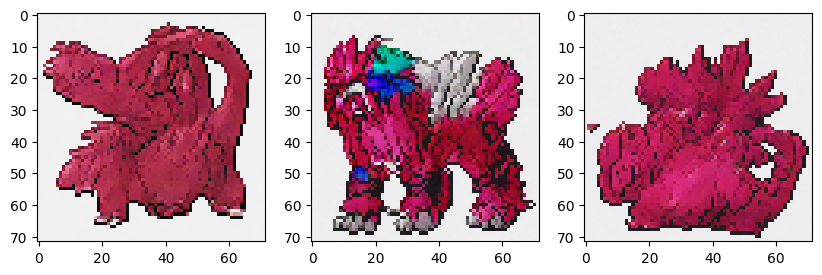

0.02434164:  95%|█████████▍| 94998/100001 [1:19:52<03:58, 20.95it/s]

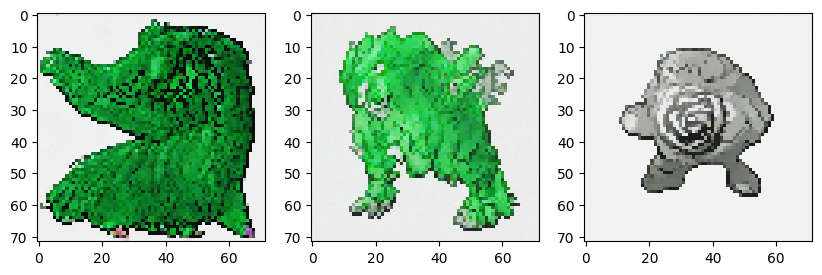

0.00926419:  96%|█████████▌| 96000/100001 [1:20:43<03:11, 20.93it/s]

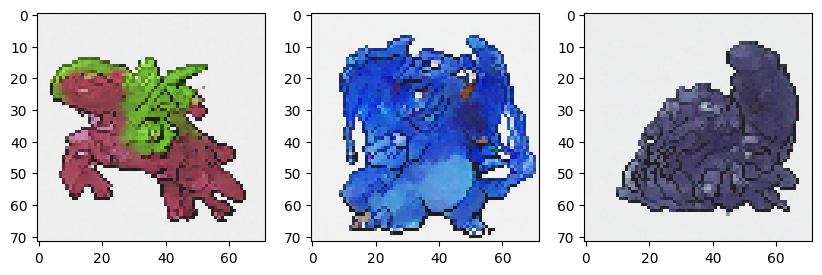

0.01348630:  97%|█████████▋| 96999/100001 [1:21:33<02:23, 20.98it/s]

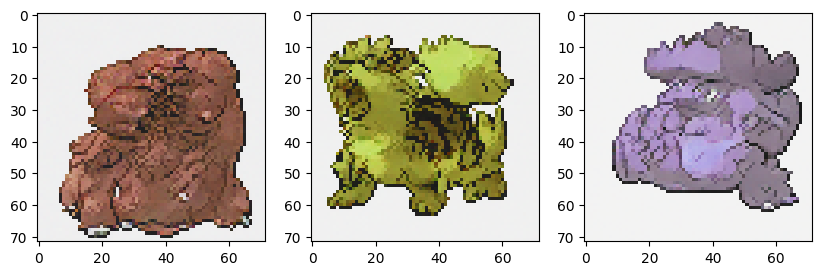

0.01846386:  98%|█████████▊| 97998/100001 [1:22:24<01:35, 20.98it/s]

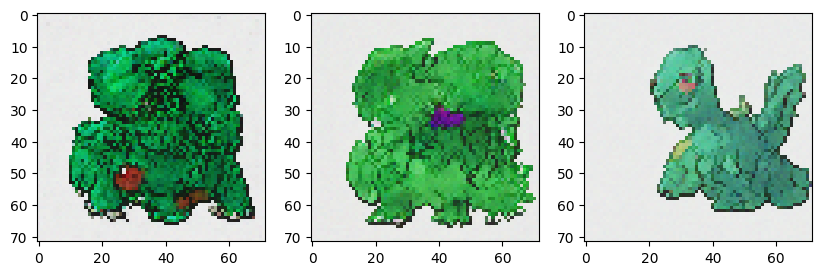

0.01372626:  99%|█████████▉| 99000/100001 [1:23:14<00:47, 20.98it/s]

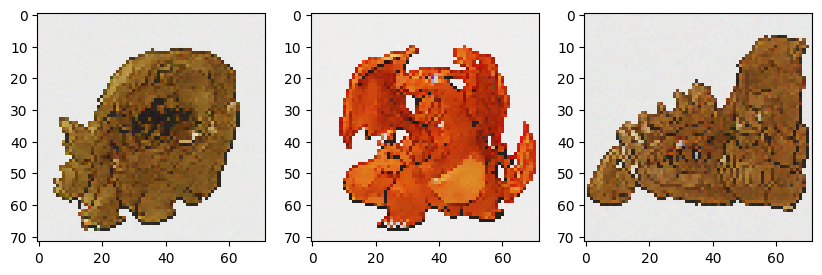

0.02520067: 100%|█████████▉| 99999/100001 [1:24:05<00:00, 20.91it/s]

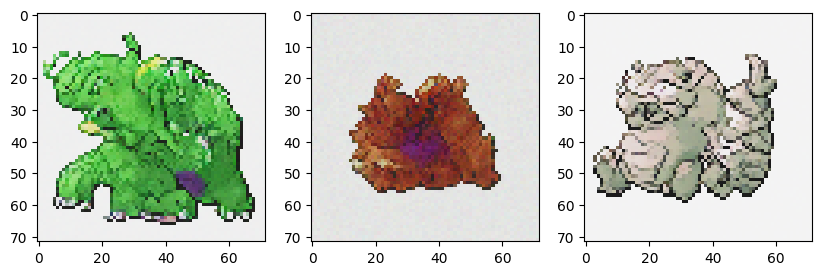

0.01479986: 100%|██████████| 100001/100001 [1:24:07<00:00, 19.81it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')